# Simulate a GPR Survey

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

def gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR):
    global c 
    c = 3e8
    v = c / np.sqrt(eps_r)
    
    xlen, tlen = region_shape # Physical extent in two dimension, in units of [m] and [t]

    # Antenna positions along surface
    x_positions = np.arange(0, xlen, dx)
    nx = len(x_positions) # The number of scans taken

    # Time axis, max penetration depth in ns
    t_samples = np.arange(0, tlen, dt)
    nt = len(t_samples) # The number of scans taken
        
    data = np.zeros((nx, nt))
    for j, x_ant in enumerate(x_positions):
        for (xr, zr) in reflectors:
            (xr, zr_m) = (xr, zr*v) # zr in [s], conv. to [m] to get twt
            
            # calculate the twt from the xr to x_ant
            twt = 2 * (np.sqrt((xr - x_ant) ** 2 + zr_m ** 2)/v) # Must convert reflector position to vel est. position [units of s]
            it = int(np.round(twt / dt)) # Convert travel time to nearest sample index
            
            # # Insert a simple spike (or Gaussian wavelet)
            if 0 <= it < nt:
                if wavetype == "spike":
                    data[j, it] = 1
                elif wavetype == "gaussian":
                    wavelet = np.exp(-(((t_samples - twt)) ** 2) * (rf**2))
                    data[j, :] += wavelet
                
                if SNR != math.inf:
                    # Gaussian noise with mean 0 and variance 1
                    noise = np.random.randn(nt)
                    noise = noise * np.std(data[j, :])/np.sqrt(SNR)
                    data[j,:]+=noise
            
    return data.T, x_positions, t_samples


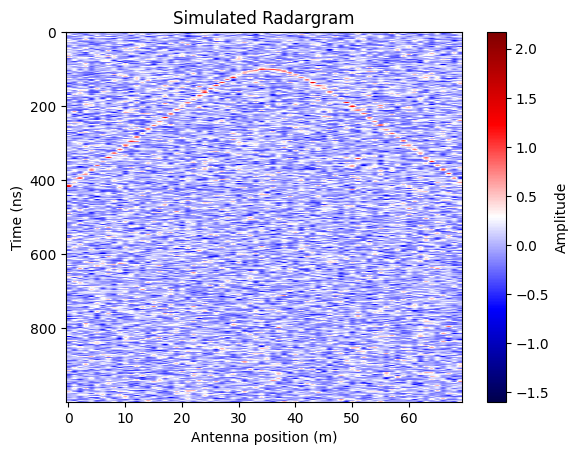

In [2]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
SNR = 0.02
wavetype = 'gaussian'

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)

plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel("Antenna position (m)")
plt.ylabel("Time (ns)")
plt.title("Simulated Radargram")
plt.colorbar(label="Amplitude")
plt.show()